### Note:
This notebook was modified 06/04/2022 from the original submission based on the following feedback:

A pdf will not be accepted—I need to see code and chart/plot in the same notebook. Why are your plots not showing in the notebook? There should be just one final notebook in the git and no png.

### Global Variables
The following cell contains files used for directory organization, global flags, and other useful files

In [1]:
# Global Variables
debug = True                        # Displays additional logging output
savePlots = False                   # Saves plot image files
targetColumnName = "TARGET"         # Name for column denoting dependant variable
outlierThreshold = 3                # Number of standard deviations from which data will be classified as an outlier
dropMissingValues = True #Needs to be true for randomTreeRegressor

# Various file names for debugging and analysis
stringVariablesFile =           './outputFiles/stringVariables.txt'
continuousVariablesFile =       './outputFiles/continuousVariables.txt'
categoricalVariablesFile =      './outputFiles/categoricalVariables.txt'
datasetName =                   './dataset/application_train.csv'
initialDataFileName =           './outputFiles/initialData.txt'
missingValFileName =            './outputFiles/missingValueSummary.txt'
noMissingValuesFileName =       './outputFiles/noMissingValueSummary.txt'
initialDistributionFileName =   './outputFiles/initialDistribution.txt'
dataFrameFileName =             './outputFiles/dataFrameDebug.txt'
generalDebugFileName =          './debug.txt'
testFileName =                  './dataset/application_test.csv'

lineString = "---------------------------------------------------------------------------------------------------------"

debugFd = open(generalDebugFileName, "w+")

if debug == True and debugFd:
    debugFd.write("Global Variables Cell Completed...\n")
    debugFd.write(lineString+"\n")

### Top 10 Variables
The following cell contains a chosenTopTenVariables list used to graph the top ten variables chosen for this assignment. TARGET is included in the list to allow the graphs to easily show the occurences of target values in scatter plots of the top 10 variables, if desired.

In [2]:
# Chosen top 10 variables from ASG1
chosenTopTenVariables = ['TARGET', 
                         'NAME_CONTRACT_TYPE',
                         'FLAG_OWN_CAR',
                         'CODE_GENDER',
                         'EXT_SOURCE_1',
                         'DAYS_BIRTH',
                         'CNT_CHILDREN',
                         'AMT_CREDIT',
                         'NAME_INCOME_TYPE',
                         'NAME_EDUCATION_TYPE',
                         'ORGANIZATION_TYPE']

if debug == True and debugFd:
    debugFd.write("Top Ten Variables Cell Completed...\n")
    debugFd.write(lineString+"\n")

### Library Inports
The following cell contains various library imports used largely for data frames, data analysis, and plotting. 

In [3]:
# Library Imports
from nis import cat
from re import X
import pandas as pd                 # Used for data frame
import plotly                       # Saves html plots
import plotly.express as px         # Used for displaying plots
import os                           # Allows file manipulation and console debugging for offline jupyter
import numpy as np
from scipy import stats             # Used for outliers
import matplotlib.pyplot as plt     # Used for pyplot heatmap plotting
import seaborn as sns               # Used for showing heatmap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
    # Import the model we are using
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.ensemble import RandomForestRegressor
#@TODO: Figure out if we want to delete this or not and use the sklearn tree
from sklearn import tree
from sklearn.datasets import load_iris
import graphviz # Data Tree Visualization

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import pickle                                   # Saving Models
from sklearn.ensemble import RandomForestClassifier

import graphviz # Data Tree Visualization
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
import pydot

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

if debug == True and debugFd:
    debugFd.write("Library Imports Cell Completed...\n")
    debugFd.write(lineString+"\n")

### Helper Functions
The below cell contains various helper functions, which have descriptions of annotations in their headers. The functions include: 
1) createOutputDirectories - vestigial functions used when I initially did this assignment and saved the plots into files

2) readData - used to read the csv file into a data frame with the target variable and the independent variables

3) dropMissingValues - drops missing values from data frame

4) writeDistribution - writes the distribution of data frame into text file. Used to show that the frequency of target variable is very much unevenly distributed towards more users successfully paying their loans than defaulting.

5) doBar - graphs a bar plot

6) plotColumn - plots an independant variable and determines based on type whether to do bar plot, distro plot, .etc

7) showTargetPlot - similar to writeDistribution, plots the target variable

8) showHeamap - graphs a heatmap of the variables

9) allocateTypes - splits dataframe into dataframes for continuous, categorical, and flags respectively.

10) insert - workaround helper function for writing into a file without overwriting contents.

11) printDataFrame - prints a data frame into a text file for manual analysis, if desired


In [4]:
# Helper Functions

# If the debugging flag is on, creates directories to store output data
#
# Parameters:
# -----------
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def createOutputDirectories(debug = False):
    if debug == False:
        return
    if not os.path.exists("images"):
        os.mkdir("images")
    if not os.path.exists("images/initialPlots"):
        os.mkdir("images/initialPlots")
    if not os.path.exists("images/topTenPlots"):
        os.mkdir("images/topTenPlots")
    if not os.path.exists("outputFiles"):
        os.mkdir("outputFiles")
    print("createOutputDirectories...success")


# Reads csv file into data frame and sets independant and dependant variables
#
# Parameters:
# -----------
# @param fileName: string for full relative file path of csv file
# @param dependantVarColumnName: csv file column matching name of column for dependant variable
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object of csv file reading
# independantVars: independant variables (all data that isn't targetColumnName)
# dependantVar: dependant variable
#
def readData(fileName, dependantVarColumnName = targetColumnName, debug = False):
    independantVars = []
    dependantVar = []
    data = pd.read_csv(fileName)
    index = None
    for i ,col in enumerate(data.columns):
        if col == dependantVarColumnName:
            index = i
    if index != None: 
        dependantVar = data.iloc[:, index]
        independantVars = data.iloc[:]
        independantVars.pop(dependantVarColumnName)
    if debug:
        fd = open(initialDataFileName, "w+")
        fd.write("This file contains the initial data frame without cleaning:\n")
        fd.write(str(data))
        fd.close()
        print("readData...completed")
    return data, independantVars, dependantVar


# Drops rows from dataset which are missing. Prints missing value data for debugging
#
# Parameters:
# -----------
# @param data: dataframe to have missing values dropped and returned
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object with missing values dropped
#
def dropMissingValues(data, debug = False):
    # Drop missing values
    ret = data.dropna(axis=0)
    # Show number of missing values per independant variable
    if debug:
        fd = open(missingValFileName, "w+")
        fd.write("This data shows the independant variables which contained missing values and the count of each:\n")
        fd.write(str(data.isnull().sum()))
        fd.close()
        fd = open(noMissingValuesFileName, "w+")
        fd.write("This data shows the independant variables which are used for analysis with no mising values:\n")
        fd.write(str(ret.isnull().sum()))
        fd.close()
        print("dropMissingValues...completed")
    return ret


# Writes distribution of data frame to text file
#
# Parameters:
# -----------
# @param data: dataframe to have distribution written to text file
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def writeDistribution(data, debug = False):
    if debug == False:
        return
    numpy_array = data.to_numpy()
    fd = open(initialDistributionFileName, "w+")
    fd.write(str(numpy_array))
    fd.close()
    print("writeDistribution...success")


def doBar(data, column_name, figsize = (18,6), 
          percentage_display = True,
          plot_defaulter = True, rotation = 0, 
          horizontal_adjust = 0, 
          fontsize_percent = 'xx-small',
          dirName = 'images/initialPlots/'):

    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)


# Plots a column name of the dataframe and saves each plot into a file
#
# Parameters:
# -----------
# @param data:       dataframe to have distribution written to text file
# @param plots:      types of plots for each column to show e.g. "box"
# @param: figsize:   size of figure for matplotlib to plot
# @param: log_scale: flag to log the scale of the plot
#
# Returns:
# ---------
# None
#
def plot_column(data,
                column_name,
                plots = [],
                figsize = (20,8),
                log_scale = False,
                dirName = 'images/initialPlots/'):

    if 'bar' in plots:
        doBar(data, column_name, figsize, dirName = dirName)
        return
    data_to_plot = data.copy()
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, len(plots), i + 1)
        plt.subplots_adjust(wspace=0.25)
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
        elif ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')
        elif ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
        elif ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)

    
# Plots distribution of TARGET variable
#
# Parameters:
# -----------
# @param data:   dataframe used for heatmap display
# @param debug:  optional flag for debugging
#
# Returns
# ---------
# None
#
def showTargetPlot(data, debug = False):
    class_dist = data[targetColumnName].value_counts()
    # Plots a Bar chart
    plt.figure(figsize=(12,3))
    plt.title('Distribution of TARGET variable')
    plt.barh(class_dist.index, class_dist.values)
    plt.yticks([0, 1])
    for i, value in enumerate(class_dist.values):
        plt.text(value-2000, i, str(value), fontsize=12, color='white',
                 horizontalalignment='right', verticalalignment='center')
    plt.show()
    # Or if you like pie more
    fig, ax1 = plt.subplots()
    ax1.pie(class_dist.values, labels = ["Successfully Paid off Loan", "Defaulted"])
    ax1.axis('equal')
    ax1.title.set_text("Pie Chart of Target Variable Frequencies")
    plt.show()

    
# Shows heatmap of all variables in data frame argument
#
# Parameters:
# -----------
# @param data:   dataframe used for heatmap display
#
# Returns
# ---------
# None
#
def showHeatmap(data):
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    plt.title("Heatmap of all Variables")
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),cmap="RdYlGn")
    plt.show()


# Allocates data frames for each data type of argument data frame
#
# Parameters:
# -----------
# @param data:   dataframe to be split into respective types
# @param debug: flag for displaying debugger output of writing columns into respective files
#
# Returns
# ---------
# strTypes           columns of string type
# continuousTypes    columns of continuous variables
# categorical        columns of categorical types
#
def allocateTypes(data, debug = False):
    strTypes = data.select_dtypes(include='object').join(data[targetColumnName])
    continuousTypes = data.select_dtypes(include = ['float64', 'int64'])
    if debug == True:
        fd = open(stringVariablesFile, "w+")
        fd.write("String-type variables:\n")
        fd.write(lineString)
        for col in strTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        fd = open(continuousVariablesFile, "w+")
        fd.write("Continuous-type variables:\n")
        fd.write(lineString)
        for col in continuousTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        print("allocateTypes...success")
    return strTypes, continuousTypes


# Workaround to insert string into file without overwriting contents
#
# Parameters:
# -----------
# @param originalfile: original file name
# @param string:       string to be written to file
#
# Returns:
# ---------
# None
#
def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('newfile.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('newfile.txt',originalfile)


# Prints a data frame
#
# Parameters:
# -----------
# @param data: dataframe to be printed
#
# Returns:
# ---------
# None
#
def printDataFrame(data):
    numpy_array = data.to_numpy()
    numpy_array = [i for i in numpy_array if str(i) != 'nan']
    
    try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%d")
    except:
        try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%s")
        except:
            try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%f")
            except: print("error in types")
    
    columnNames = ""
    for i in data.columns:
        columnNames = columnNames + i + " "
    columnNames = columnNames + "\n"
    insert(dataFrameFileName, columnNames)


if debug == True and debugFd:
    debugFd.write("Helper Functions Cell Completed...\n")
    debugFd.write(lineString+"\n")

### Read Data
This creates output directories for debugging and saving plots, if desired, and reads in the data.

In [5]:
# Create output directories for files and plots to be saved to
createOutputDirectories(debug)
# Read the data, assigning independant and dependant variables
data, x, y = readData(datasetName, targetColumnName, debug)

if debug == True and debugFd:
    debugFd.write("Dataset imported...\n")
    debugFd.write(lineString+"\n")

createOutputDirectories...success
readData...completed


### Perform Basic Analysis
The below cell should show a heatmap of the data points and the distribution of the target variable

This shows that the TARGET variable is not evenly distributed

It should also show a heatmap with correlation between various variables. This is useful in that some of the variables have some stronger correlation with the TARGET variable, e.g. EXT_SOURCE1,2,3, APPARTMENTS_AVG, TOTALAREA_MODE, FLOORSMIN_MEDI, and FLOORSMAX_MEDI

Since few variables have high correlations with target, it may be most useful to pick variables that correlate with TARGET (and have lower correlations with eachother, or pick perhaps one of each correlation group, for example a single EXT_SOURCE, a single feature denoting something about the user's real estate data, etc.)

Additionally, some thought should go into selecting independant variables that are missing a significant amount of entries, as shown by the print out of variables with more than 5% null values. 

OWN_CAR_AGE                     202929
OCCUPATION_TYPE                  96391
EXT_SOURCE_1                    173378
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE                 156061
BASEMENTAREA_MODE               179943
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BUILD_MODE                204488
COMMONAREA_MODE                 214865
ELEVATORS_MODE                  163891
ENTRANCES_MODE                  154828
FLOORSMAX_MODE           

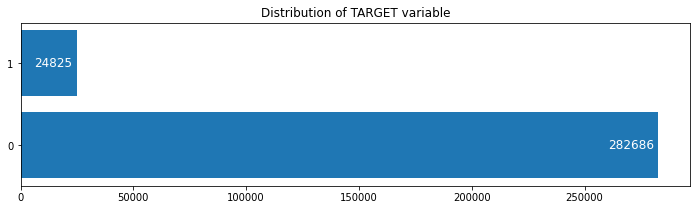

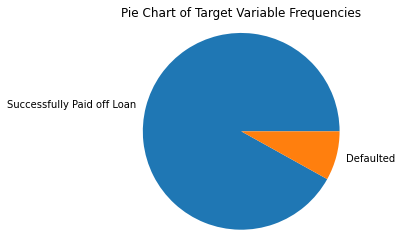

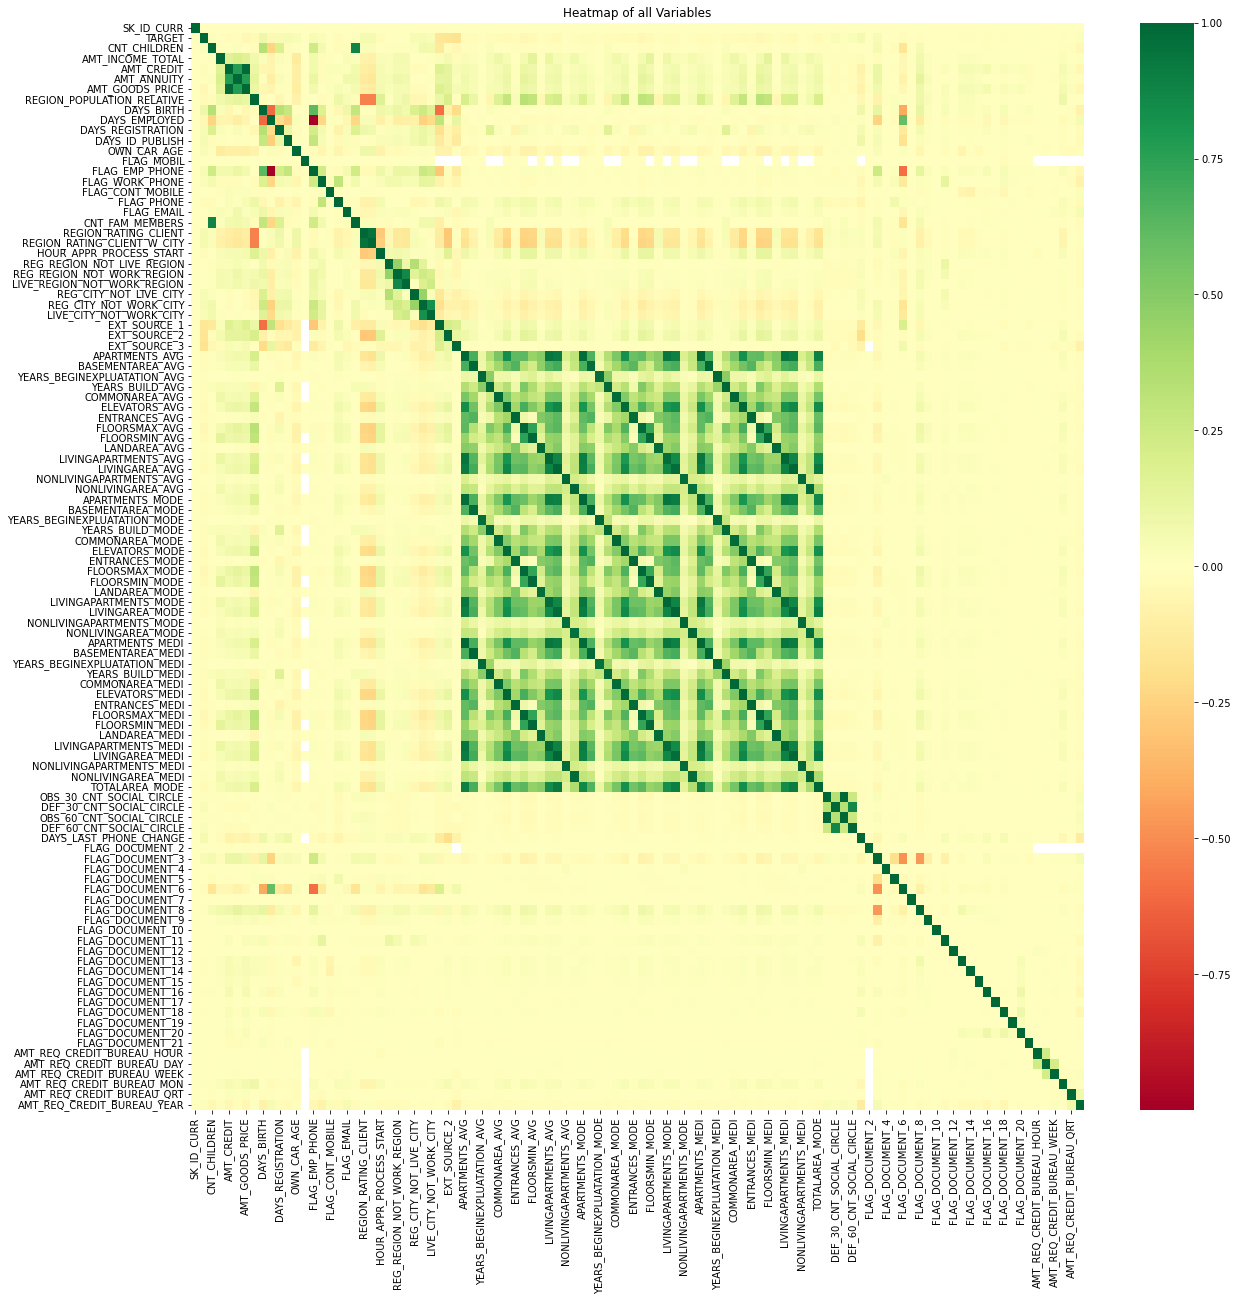

writeDistribution...success


In [6]:
# Shows Entries with more than 5% null values
if debug == True:
    print(data.isnull().sum()[data.isnull().sum() > data.shape[0] * .05])
# Shows distribution of the independant variable, and shows heamap
showTargetPlot(data, debug)
showHeatmap(data)
# Show data distribution and allow for manual analysis of outliers
writeDistribution(data, debug)

if debug == True and debugFd:
    debugFd.write("General Dataset analysis completed...\n")
    debugFd.write(lineString+"\n")

### Plotting All Variables
The below cell splits the variables into appropriate values, and plots all of them, saving the plots into the images directory for manual analysis.

#### Warning: Running this cell will plot all variables and consume quite a lot of CPU/GPU resources

In [10]:
plotAllVariables = False

# Get sub-data frames that contain variables from each respective data type
data_strings, data_continuous = allocateTypes(data, debug)

if plotAllVariables:
    for i in data_strings.columns:
        plot_column(data_strings, i, ['box'])
    for i in data_continuous.columns:
        plot_column(data_continuous, i, ['box'])

allocateTypes...success


### Showing Correlations
The following block outputs the top 10 independant variables correlated with data. They also have high correlation amongst themselves as well (the EXT_SOURCE credits, some DAYS time-related variables, and some REGION area-related variables.). 

If we plot the top 20 variables with correlation, we see some home-feature variables as well. 

In [11]:
print("Top 10 Variables correlated with TARGET")
print(lineString)
# Just show 11 for now rather than removing target
print(data.corr()['TARGET'].abs().sort_values(ascending = False).head(11))

Top 10 Variables correlated with TARGET
---------------------------------------------------------------------------------------------------------
TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
Name: TARGET, dtype: float64


### Plotting Top 10 Variables
After performing analysis as described in the initial pdf submission, the top 10 variables can be plotted by the code in the cell below.

The plots will also be saved to the images/topTenPlots directory for later convenience. 

In [15]:
# Show plots for chosen variables
topTenDf = data[chosenTopTenVariables]
# 10 plus TARGET
assert(len(topTenDf.columns) == 11)
# Allocate types for plotting
topTenStrings, topTenContinuous = allocateTypes(topTenDf, debug)

allocateTypes...success


#### Plotting Categorical Types

Total Number of unique categories of NAME_CONTRACT_TYPE = 2
Total Number of unique categories of FLAG_OWN_CAR = 2
Total Number of unique categories of CODE_GENDER = 3
Total Number of unique categories of NAME_INCOME_TYPE = 8
Total Number of unique categories of NAME_EDUCATION_TYPE = 5
Total Number of unique categories of ORGANIZATION_TYPE = 58


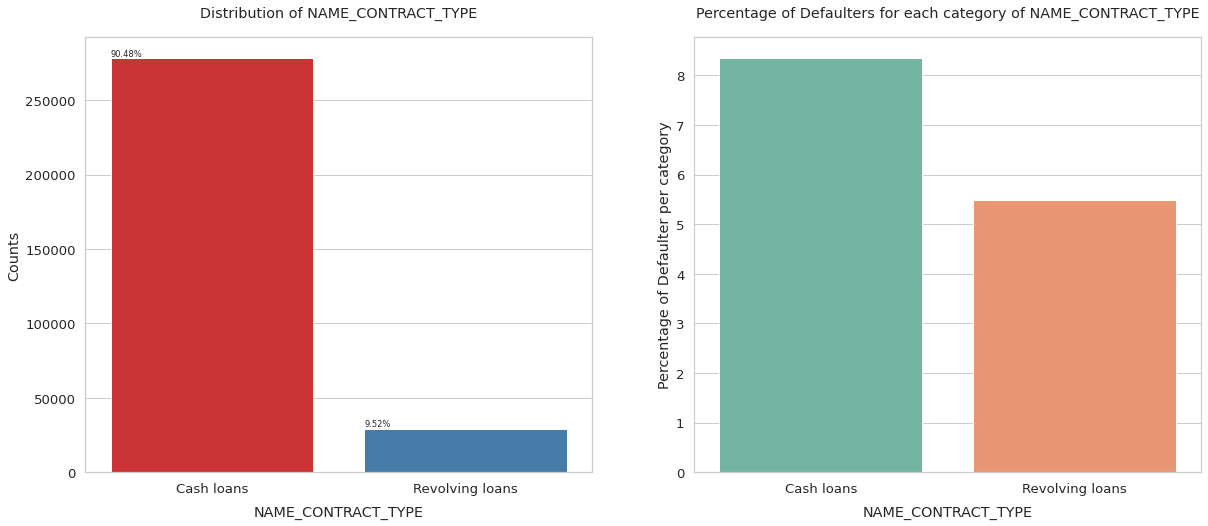

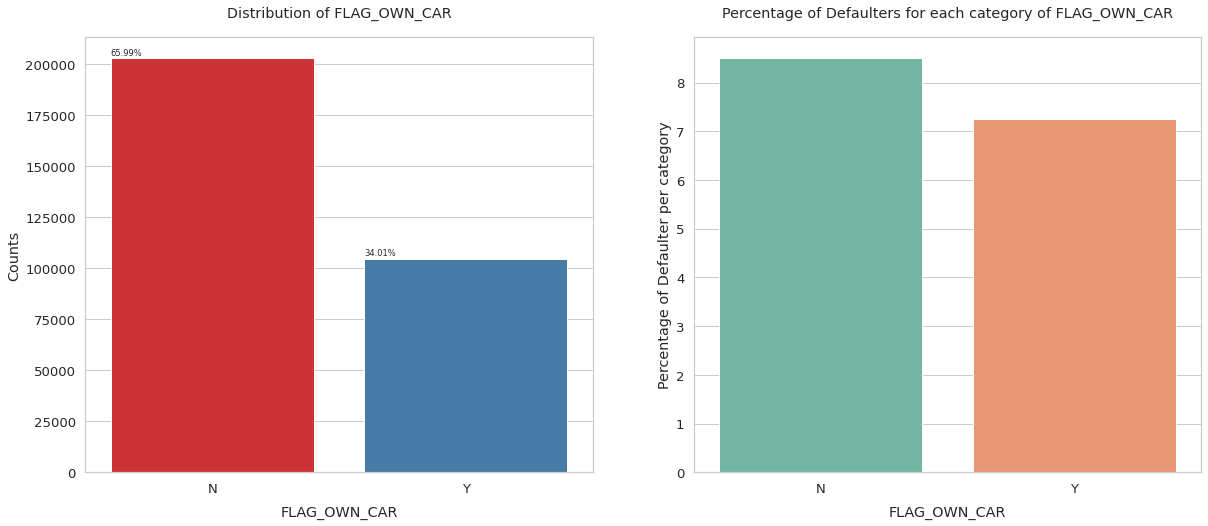

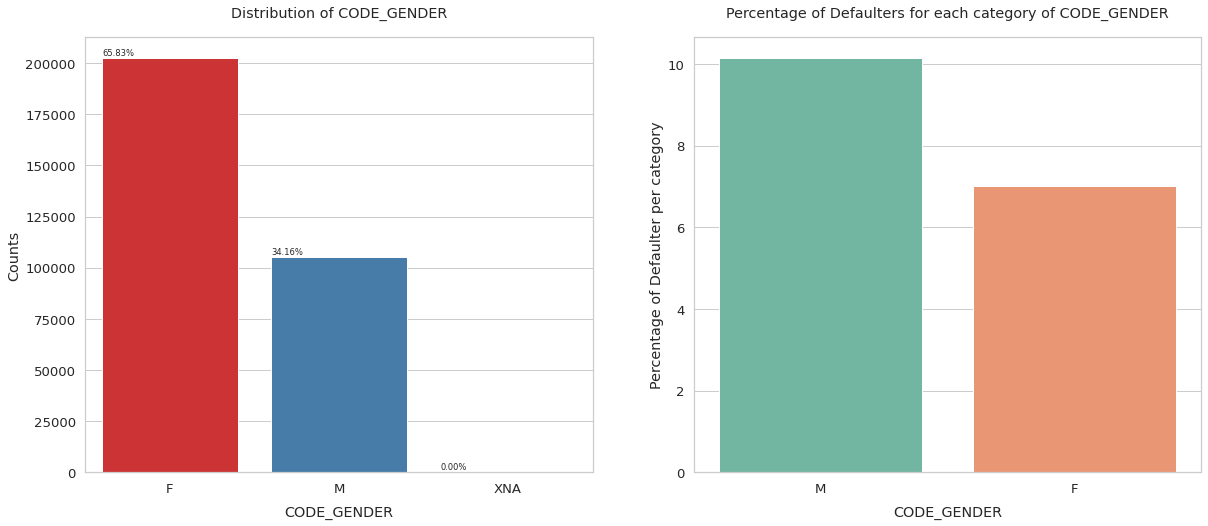

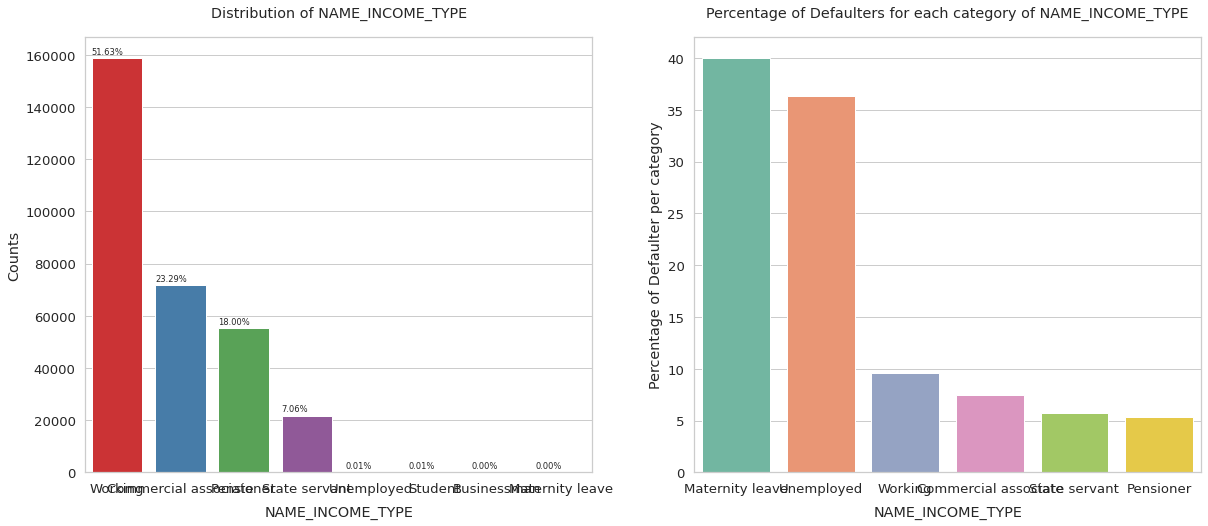

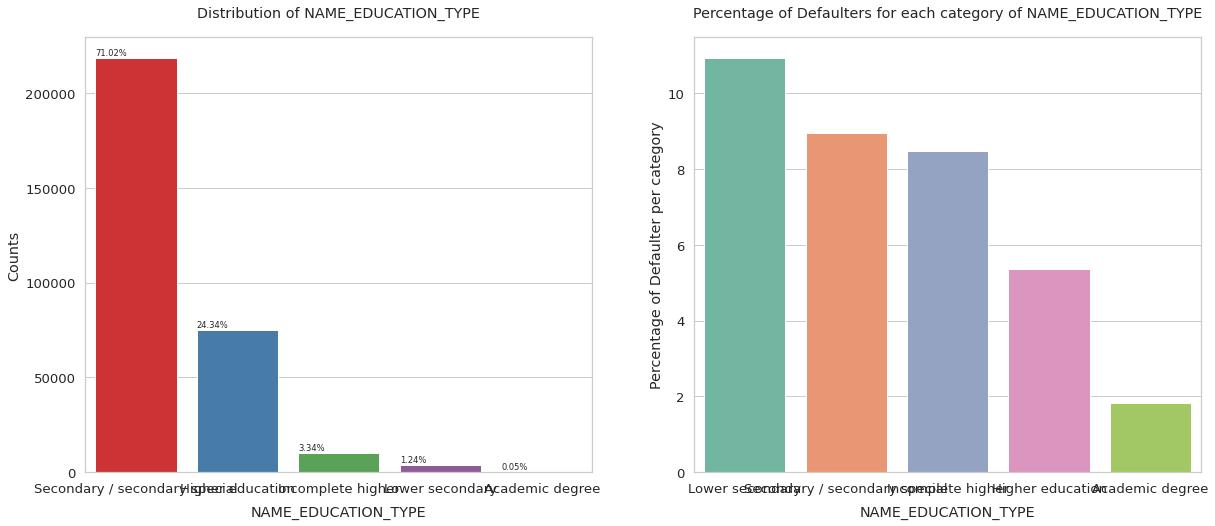

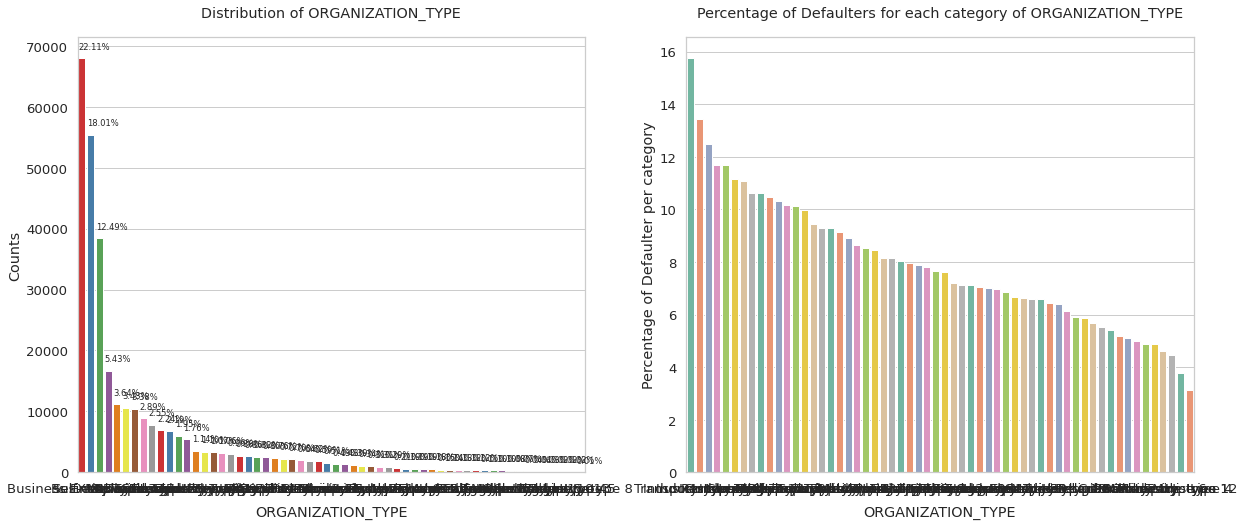

In [17]:
for i in topTenStrings.columns:
    if i == targetColumnName:
        continue
    plot_column(topTenStrings, i, ['bar'], dirName = 'images/topTenPlots/')

#### Plotting Continuous Types

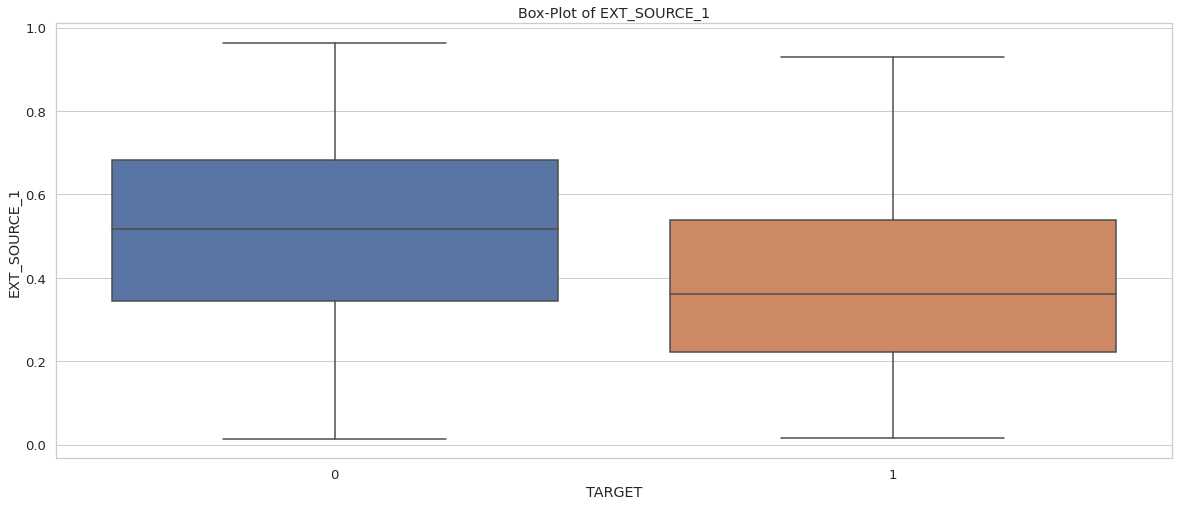

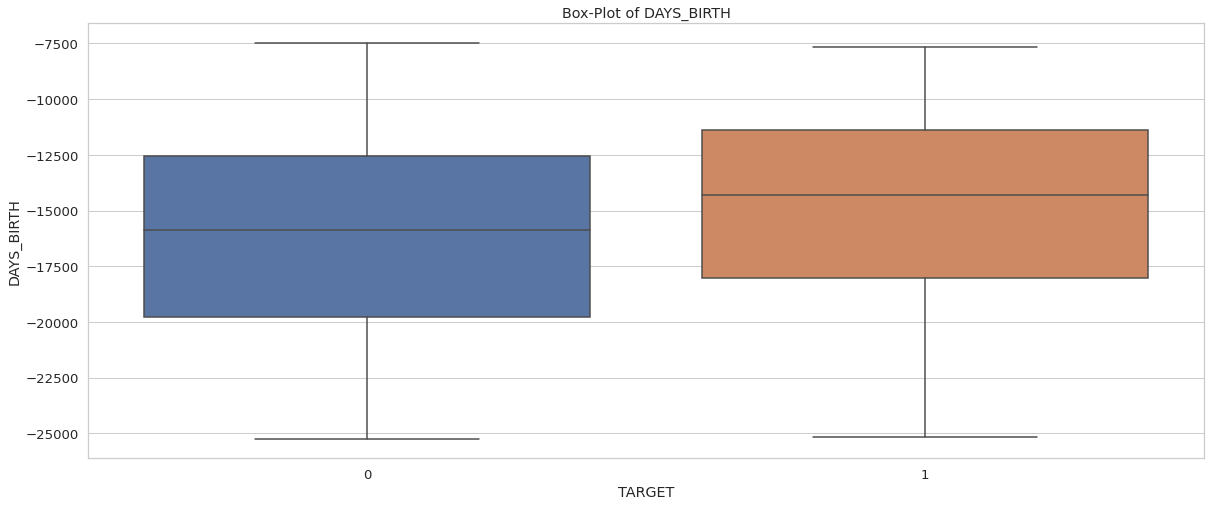

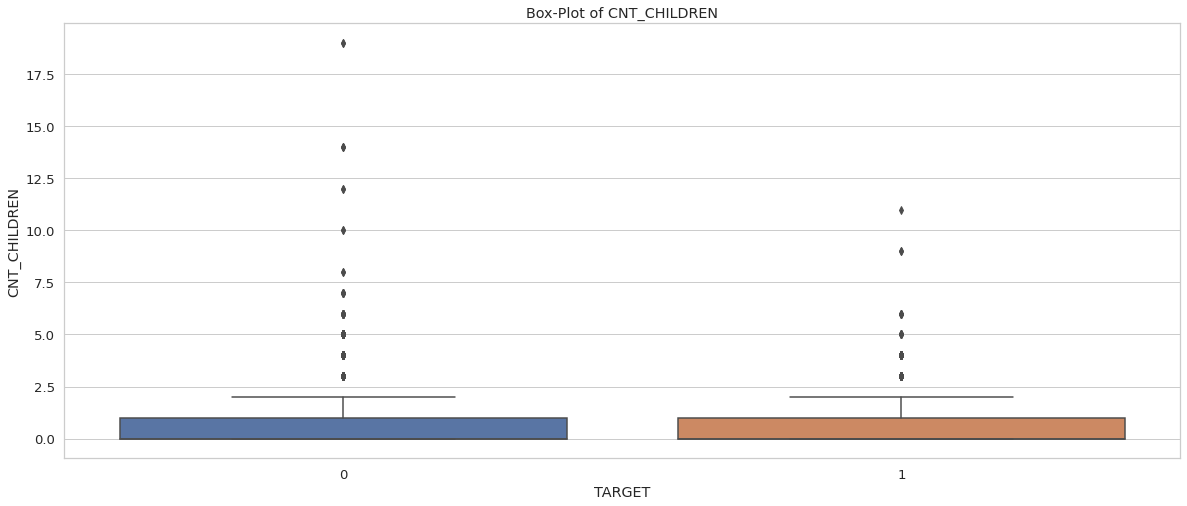

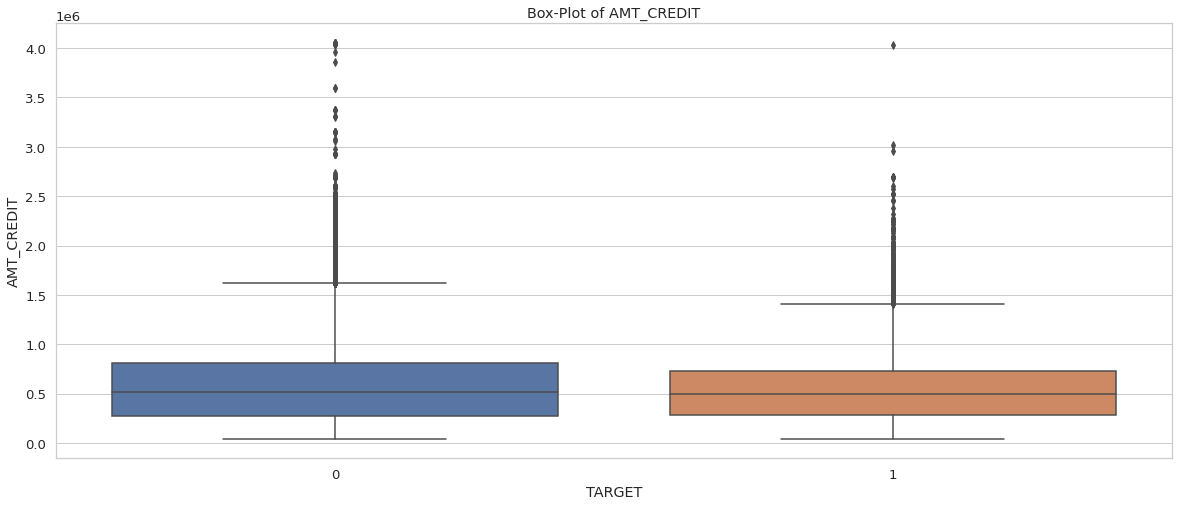

In [14]:
for i in topTenContinuous.columns:
    if i == targetColumnName:
        continue
    plot_column(topTenContinuous, i, ['box'], dirName = 'images/topTenPlots/')

#### Histograms of Continuous Types

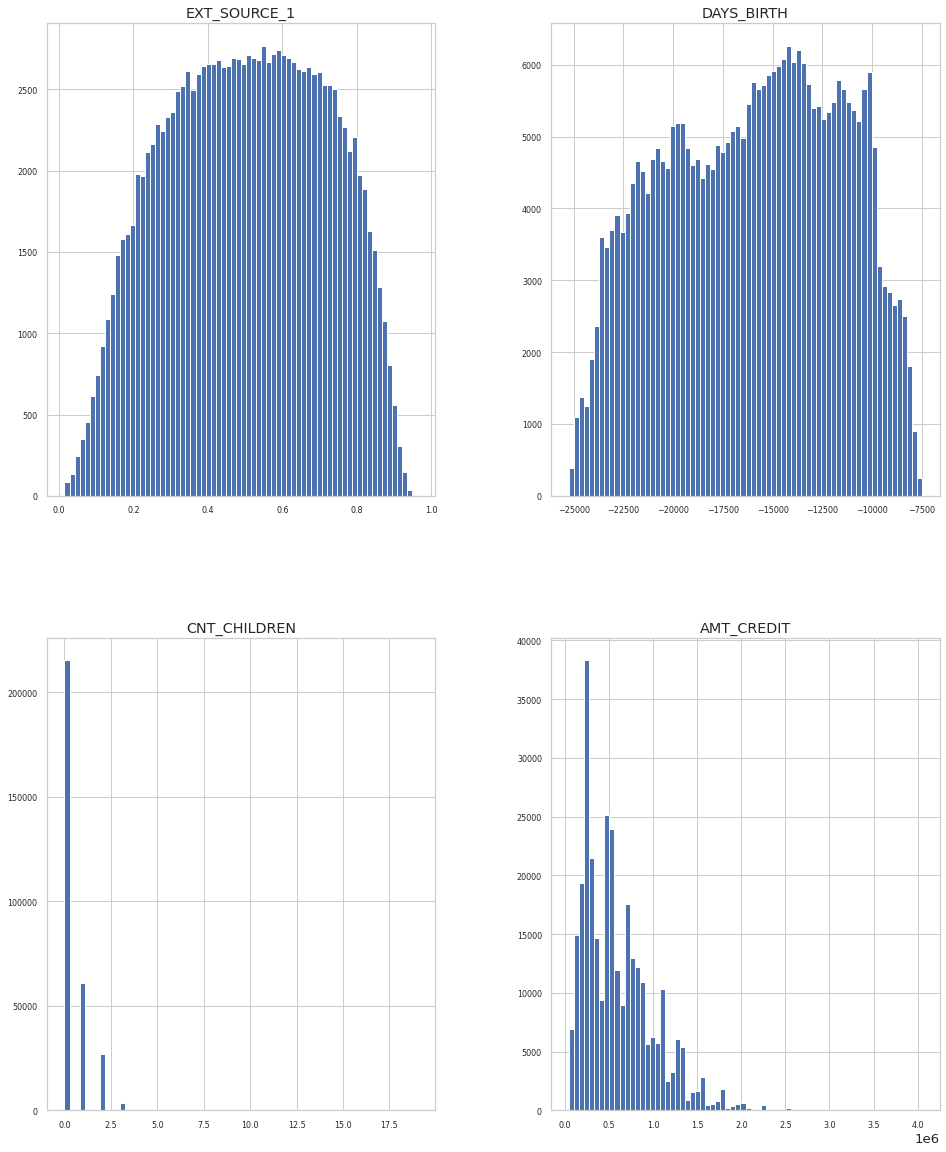

In [19]:
topTenContinuous.drop(targetColumnName, axis=1).hist(figsize=(16, 20), bins=70, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

#### Plotting CNT_CHILDREN as Categorical
The number of unique vales for CNT_CHILDREN are fairly low in terms of maximum distribution, so changes are later in data cleaning we will move the variable into a category and likely aggregate some of the higher occurences as either outliers that are removed altogether, or as combined category eg. "cnt_children_gtr_4"

In [20]:
topTenContinuous['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

Total Number of unique categories of CNT_CHILDREN = 15


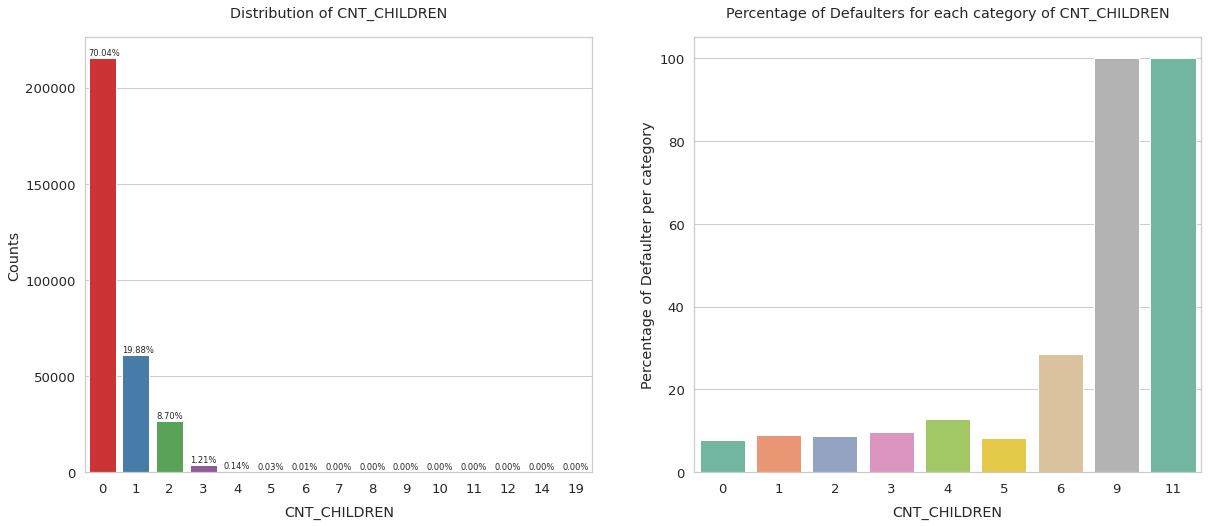

In [22]:
plot_column(topTenContinuous, 'CNT_CHILDREN', ['bar'])

#### Splitting up CNT_CHILDREN
As we see from our distributions and our initial, uncleaned bar plot, the count of children seems to have some increasing percents at various thresholds, but it is also difficult to see as the pairs entries for 9 and 11 children respectively defaulted. 

In [23]:
topTenContinuous2 = topTenContinuous.copy()
# Remove values > 5
topTenContinuous2['CNT_CHILDREN'] = np.where(topTenContinuous2['CNT_CHILDREN'] > 5, 
                                             np.NaN, 
                                             topTenContinuous2['CNT_CHILDREN'])
topTenContinuous2['CNT_CHILDREN'].value_counts()

0.0    215371
1.0     61119
2.0     26749
3.0      3717
4.0       429
5.0        84
Name: CNT_CHILDREN, dtype: int64

Total Number of unique categories of CNT_CHILDREN = 7


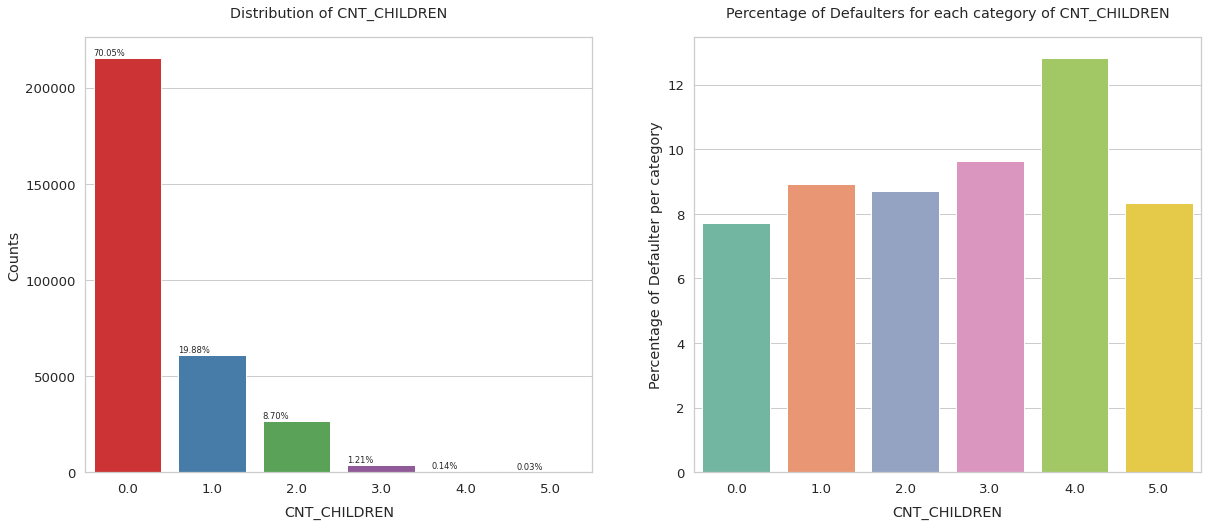

In [24]:
plot_column(topTenContinuous2, 'CNT_CHILDREN', ['bar'])